A *conservation law* is a type of PDE that describes the transport of extensive quantities like mass, momentum, and energy.
The most general form of a hyperbolic conservation law for a field $q$ is

$$\frac{\partial q}{\partial t} + \nabla\cdot f(q) = s,$$

where $f$ is the *flux* function and $s$ the sources.
The solution variable $q$ could be a scalar, vector, or tensor field.
Here we'll look at the simplest conservation law of them all, the *advection equation*: $q$ is a scalar field and $f(q) = qu$ for some velocity field $u$.
As we'll see, there are lots of ways to screw up something as simple as the advection equation, so learning what the common error modes are will help when attacking harder problems like the shallow water or Euler equations.

One of the challenging things about solving hyperbolic problems is that the class of reasonable solutions includes functions with jump discontinuities, and for some problems this is true even when the initial data are smooth.
Compare that to, say, elliptic problems, where the solution is almost always smoother than the input data.
For elliptic problems, it's common to use continuous basis functions, but when we try to use the same basis for conservation laws we can run up against some very nasty stability problems.
It's possible to work around these issues by using tricks like the streamlined upwind Petrov-Galerkin method.
But almost any approach to stabilizing a CG discretization introduces (1) free parameters that can be difficult to tune right and (2) an unrealistic level of numerical diffusion.
For these reasons, the **discontinuous Galerkin method** is very popular for these kinds of problems.
The DG method has good local conservation properties, it can achieve high-order accuracy where the solution is smooth, and there are more options in how you guarantee a stable scheme.

DG is a huge subject and I couldn't possibly do justice to it here.
If you want to read more about it, [this paper](https://rdcu.be/b21NB) by Cockburn and Shu is a great reference, as are these [notes](https://elib.dlr.de/57074/1/Har08b.pdf) by Ralf Hartmann and this [dissertation](http://eprints.maths.manchester.ac.uk/2347/1/Dissertation.pdf) by Michael Crabb.
Instead, I'll focus here on the effects of some of the choices you have to make when you solve these types of problems.

### Input data

First, we want to create a domain, some function spaces, and a divergence-free velocity field $u$.
The classic example is a material in uniform solid-body rotation around some fixed point $y$:

$$u(x) = \hat k \times (x - y)$$

where $\hat k$ is the unit vector in the $z$ direction.

In [1]:
import firedrake
from firedrake import inner, Constant, as_vector
mesh = firedrake.UnitSquareMesh(64, 64, diagonal='crossed')
x = firedrake.SpatialCoordinate(mesh)
y = Constant((.5, .5))
r = x - y
u = as_vector((-r[1], r[0]))

To have a stable timestepping scheme, we'll need to satisfy the [Courant-Friedrichs-Lewy condition](https://en.wikipedia.org/wiki/Courant%E2%80%93Friedrichs%E2%80%93Lewy_condition), which means calculating the maximum speed and the minimum cell diameter.
Calculating the maximum speed exactly can be challenging; if $u$ is represented with piecewise linear basis functions, then $|u|^2$ is a quadratic function and thus might not attain its maximum value at the interpolation points.
You could work around this by changing to a basis of [Bernstein polynomials](https://en.wikipedia.org/wiki/Bernstein_polynomial), but for our purposes it'll be enough to evaluate the maximum at the interpolation points and take a smaller timestep than necessary.

In [2]:
import numpy as np
Q = firedrake.FunctionSpace(mesh, family='CG', degree=2)
speed = firedrake.Function(Q).interpolate(inner(u, u))
max_speed = np.sqrt(speed.dat.data_ro.max())

Q0 = firedrake.FunctionSpace(mesh, family='DG', degree=0)
diameters = firedrake.project(firedrake.CellDiameter(mesh), Q0)
min_diameter = diameters.dat.data_ro.min()

cfl_timestep = min_diameter / max_speed
print('Upper bound for CFL-stable timestep: {}'.format(cfl_timestep))

Upper bound for CFL-stable timestep: 0.022097086912079608


The initial data we'll use will be the classic bell and cone:

$$q_0 = \max\{0, 1 - |x - x_c| / r_c\} + \max\{0, 1 - |x - x_b|^2 / r_b^2\}$$

where $x_c$, $r_c$ are the center and radius of the cone and $x_b$, $r_b$ for the bell.

In [3]:
from firedrake import sqrt, min_value, max_value

x_c = as_vector((5/8, 5/8))
R_c = Constant(1/8)

x_b = as_vector((3/8, 3/8))
R_b = Constant(1/8)

q_expr = (
    max_value(0, 1 - sqrt(inner(x - x_c, x - x_c) / R_c**2)) +
    max_value(0, 1 - inner(x - x_b, x - x_b) / R_b**2)
)
q0 = firedrake.project(q_expr, Q0)

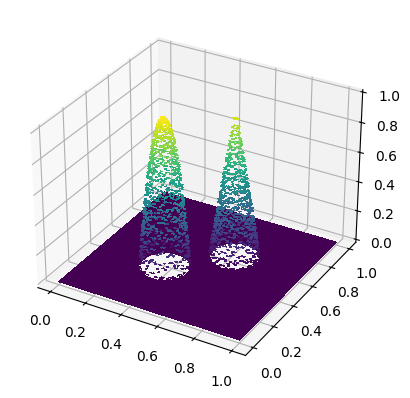

In [4]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
fig = plt.figure()
axes = fig.add_subplot(projection='3d')
firedrake.trisurf(q0, axes=axes);

### Fluxes

For our first experiment we'll look at the problem of choosing a *numerical flux*.
As we'll see in the following, we have choices to make in how we determine the discrete approximation to the solution of the conservation law.
This is very different from elliptic problems -- once we've decided to use the continous Galerkin method, the only real choice is what polynomial degree we'll use.

The usual procedure to come up with a weak form for a PDE is to multiply by some smooth test function $\phi$, move some derivatives onto $\phi$, and integrate.
For the conservation law written above, we would arrive at the weak form

$$\int_\Omega\left(\frac{\partial q}{\partial t}\cdot\phi - f(q)\cdot\nabla\phi\right)dx = \int_\Omega s\cdot\phi\, dx + \ldots$$

where I've used an ellipsis to stand for some boundary terms that don't particularly matter.
Unfortunately, this equation doesn't quite tell the whole story.
We're using discontinuous basis functions to represent the solution $q$, and ideally we would use the same basis and test functions.
What happens when the test functions are discontinuous too?

Let $\phi$ be some basis function and let $K$ be the cell of the domain where $\phi$ is supported.
If we apply the usual procedure, we get an element-wise weak form when integrating against $\phi$:

$$\int_K\left(\frac{\partial q}{\partial t}\phi - f(q)\cdot\nabla\phi\right)dx + \int_{\partial K}f(q)\cdot\phi n\, ds = \int_K s\cdot\phi\, dx + \ldots$$

where $n$ is the unit outward normal vector to $K$.
Note that we're integrating over only a single element and not the entire domain.
The problem here is that **if the solution and the basis functions are discontinuous across the element, we can't uniquely define their values on the boundary**.

To see why this is so, you can imagine that, instead of having a discontinuous test function, we have a sequence $\phi_\epsilon$ of continuous test functions that converge to $\phi$ in some appropriate norm.
If we take the support of each element of the sequence to be contained in the interior of $K$, then the value of $q$ in the boundary integral will its the value approaching the boundary from inside:

$$q_-(x) = \lim_{\epsilon\to 0}q(x - \epsilon n).$$

Alternatively, if we take $K$ to be contained in the interior of the support of each element of the sequence, then the value of the solution in the boundary integral will be its value approach the boundary from the outside:

$$q_+(x) = \lim_{\epsilon\to 0}q(x + \epsilon n).$$

Finally, with the right choice of sequence we could get any weighted average of the values on either side of the interface.
As a consequence, we need to make some choice of the **numerical flux**.
The numerical flux $f^*$ is a function of the interface values $q_+$ and $q_-$ and the unit normal vector $n$.
The discrete approximation to the solution will satisfy the ODE system

$$\sum_K\left\{\int_K\left(\frac{\partial q}{\partial t}\phi - f(q)\cdot\nabla\phi\right)dx + \int_{\partial K}f^*(q_-, q_+, n)\cdot\phi\, ds\right\} = \sum_K\int_K s\cdot\phi\, dx + \ldots$$

for all test functions $\phi$.
What kinds of functions can make a good numerical flux?
First, if the solution is continuous across an element boundary, the numerical flux should give the same value as the true physical flux:

$$f^*(q, q, n) = f(q)\cdot n.$$

This condition is called **consistency** and it guarantees that the exact solution is also a discrete solution.
The second property we want is to have some analogue of the conservative nature of the true problem.
The important thing about fluxes in physical problems is that they can't create or destroy mass, momentum, energy, etc., they only transport it around the domain.
To see how we can attain a similar property for our discrete problem, first observe that the sum over all the boundary integrals is telescoping because two neighboring cells $K_-$, $K_+$ share a common face $E$.
We can then rewrite the sum of all the boundary integrals as a sum over all faces $E$ of the mesh:

$$\sum_K\int_{\partial K}f^*(q_-, q_+, n)\phi\, ds = \sum_E\int_E\left\{f^*(q_-, q_+, n_-)\phi_- + f^*(q_+, q_-, n_+)\phi_+\right\}ds$$

here $n_-$, $n_+$ are the unit outwardn ormal vectors to $K_-$ and $K_+$ respectively.
Note that $n_+ = -n_-$, i.e. the two normals point in opposite directions to each other.
What happens if the test function $\phi$ is identically equal to 1 throughout the entire domain?
In that case the facet integrals should sum up to 0 -- fluxes only transport, they don't create or destroy.
The numerical flux is **conservative** if

$$f^*(q_-, q_+, n) + f^*(q_+, q_-, -n) = 0.$$

The most braindead way we can come up with a sane numerical flux is to take the average of the solution values across the cell boundary:

$$f^*(q_-, q_+, n) = \frac{1}{2}(q_- + q_+)\cdot n.$$

This is called the *central flux*.
Let's see how well it works.

In [5]:
from firedrake import grad, dx, ds, dS

q, ϕ = firedrake.TrialFunction(Q0), firedrake.TestFunction(Q0)
m = q * ϕ * dx

q = q0.copy(deepcopy=True)
cell_flux = -inner(grad(ϕ), q * u) * dx

n = firedrake.FacetNormal(mesh)
f = q * inner(u, n)
face_flux = (f('+') - f('-')) * (ϕ('+') - ϕ('-')) * dS

q_in = Constant(0)
influx = q_in * min_value(0, inner(u, n)) * ϕ * ds
outflux = q * max_value(0, inner(u, n)) * ϕ * ds

We'll take our timestep to be 1/4 of the formal CFL-stable timestep.
We need at least a factor of 1/2 for the dimension, and probably another factor of 1/2 for triangle shape.

In [6]:
from numpy import pi as π
final_time = 2 * π
num_steps = 4 * int(final_time / cfl_timestep)
dt = Constant(final_time / num_steps)

Since we're repeatedly solving the same linear system, we'll create problem and solver objects so that this information can be reused from one solve to the next.
The solver parameters are specially chosen for the fact that the mass matrix with discontinuous Galerkin methods is block diagonal, so a block Jacobi preconditioner with exact solvers on all the blocks is exact for the whole system.

In [7]:
from firedrake import LinearVariationalProblem, LinearVariationalSolver
dq_dt = -(cell_flux + face_flux + influx + outflux)

δq = firedrake.Function(Q0)
problem = LinearVariationalProblem(m, dt * dq_dt, δq)
parameters = {'ksp_type': 'preonly', 'pc_type': 'bjacobi', 'sub_pc_type': 'ilu'}
solver = LinearVariationalSolver(problem, solver_parameters=parameters)

In [8]:
import numpy as np
qrange = np.zeros((num_steps, 2))

from tqdm.notebook import trange
for step in trange(num_steps, unit='timesteps'):
    solver.solve()
    q += δq
    qrange[step, :] = q.dat.data_ro.min(), q.dat.data_ro.max()

  0%|          | 0/1136 [00:00<?, ?timesteps/s]

After only 250 steps the solution is already attaining values two orders of magnitude greater than what they should, even while using a CFL-stable timestep.
The reason for this is that the central flux, while both consistent and conservative, is numerically unstable with forward time-differencing.

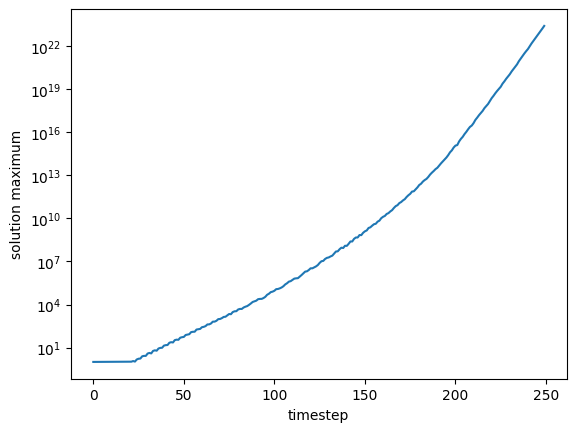

In [9]:
fig, axes = plt.subplots()
axes.set_yscale('log')
axes.plot(qrange[:250, 1])
axes.set_xlabel('timestep')
axes.set_ylabel('solution maximum');

Instead, we'll try the *upwind* numerical flux.
The idea of the upwind flux is to sample from whichever side of the interface has the velocity flowing outward and not in.
The numerical flux is defined as

$$f^*(q_-, q_+, n) = \begin{cases}q_-u\cdot n && u\cdot n > 0 \\ q_+u\cdot n && u\cdot n \le 0\end{cases}.$$

We can also write this in a more symmetric form as

$$f^*(q_-, q_+, n) = q_-\max\{0, u\cdot n\} + q_+\min\{0, u\cdot n\}.$$


The upwind flux is designed to mimic the stability properties of one-sided finite difference schemes for transport equations.

In [10]:
q = q0.copy(deepcopy=True)
cell_flux = -inner(grad(ϕ), q * u) * dx

n = firedrake.FacetNormal(mesh)
u_n = max_value(inner(u, n), 0)
f = q * u_n
face_flux = (f('+') - f('-')) * (ϕ('+') - ϕ('-')) * dS

q_in = Constant(0)
influx = q_in * min_value(0, inner(u, n)) * ϕ * ds
outflux = q * max_value(0, inner(u, n)) * ϕ * ds
       
dq_dt = -(cell_flux + face_flux + influx + outflux)

δq = firedrake.Function(Q0)
problem = LinearVariationalProblem(m, dt * dq_dt, δq)
parameters = {'ksp_type': 'preonly', 'pc_type': 'bjacobi', 'sub_pc_type': 'ilu'}
solver = LinearVariationalSolver(problem, solver_parameters=parameters)

qs = []
output_freq = 5

for step in trange(num_steps, unit='timesteps'):
    solver.solve()
    q += δq
    if step % output_freq == 0:
        qs.append(q.copy(deepcopy=True))

  0%|          | 0/1136 [00:00<?, ?timesteps/s]

We at least get a finite answer as a result, which is a big improvement.
Keeping in mind that the original data capped out at a value of 1, the peaks have shrunk considerably, and we can also see that the sharp cone is much more rounded than before.

In [11]:
from firedrake.plot import FunctionPlotter
fn_plotter = FunctionPlotter(mesh, num_sample_points=1)

In [12]:
%%capture
fig, axes = plt.subplots()
axes.set_aspect('equal')
axes.get_xaxis().set_visible(False)
axes.get_yaxis().set_visible(False)
colors = firedrake.tripcolor(
    q, num_sample_points=1, vmin=0., vmax=1., shading="gouraud", axes=axes
)

from matplotlib.animation import FuncAnimation
def animate(q):
    colors.set_array(fn_plotter(q))

interval = 1e3 * output_freq * float(dt)
animation = FuncAnimation(fig, animate, frames=qs, interval=interval)

In [13]:
from IPython.display import HTML
HTML(animation.to_html5_video())

Despite this fact, the total volume under the surface has been conserved to within rounding error.

In [14]:
print(firedrake.assemble(q * dx) / firedrake.assemble(q0 * dx))

0.9999713508961614


Nonetheless, the relative error in the $L^1$ norm is quite poor.

In [15]:
firedrake.assemble(abs(q - q0) * dx) / firedrake.assemble(q0 * dx)

np.float64(0.6651047426779901)

Let's see if we can improve on that by changing the finite element basis.

### Higher-order basis functions

One of the main advantages that the discontinuous Galerkin method has over the finite volume method is that achieving higher-order convergence is straightforward if the problem is nice -- you just increase the polynomial degree.
(When the problem is not nice, for example if there are shockwaves, everything goes straight to hell and the finite volume method is much less finicky about stability.)
Here we'll look at what happens when we go from piecewise constant basis functions to piecewise linear.

One of the first changes we have to make is that the Courant-Friedrichs-Lewy condition is more stringent for higher-order basis functions.
For piecewise constant basis functions, we have that $\delta x / \delta t \ge |u|$; for degree-$p$ polynomials, we instead need that

$$\frac{\delta x}{\delta t} \ge (2p + 1)\cdot|u|.$$

One way of looking at this higher-degree CFL condition is that the introduction of more degrees of freedom makes the effective spacing between the nodes smaller than it might be in the piecewise-constant case.
The multiplicative factor of $2p + 1$ accounts for the effective shrinkage in the numerical length scale.
(For more, see [this paper](https://doi.org/10.1016/j.apnum.2013.04.003) from 2013.)
Once again, we'll use a timestep that's 1/4 of the formal CFL timestep to account for the spatial dimension and the mesh quality.

In [16]:
cfl_timestep = min_diameter / max_speed / 3
num_steps = 4 * int(final_time / cfl_timestep)
dt = Constant(final_time / num_steps)

We have to be a bit carefuly about creating the initial data.
For discontinuous Galerkin discretizations, we would normally project the expression into the discrete function space.
Since this is a projection in $L^2$, we might get negative values for an otherwise strictly positive expression.
In this case, the positivity of the solution is vital and so instead I'm interpolating the expression for the initial data, but doing so is a little dangerous.

In [17]:
Q1 = firedrake.FunctionSpace(mesh, family='DG', degree=1)
q0 = firedrake.Function(Q1).interpolate(q_expr)
q0.dat.data_ro.min(), q0.dat.data_ro.max()

(np.float64(0.0), np.float64(0.9990945067964072))

In almost every other respect the discretization is the same as before.

In [18]:
q, ϕ = firedrake.TrialFunction(Q1), firedrake.TestFunction(Q1)
m = q * ϕ * dx

q = q0.copy(deepcopy=True)
cell_flux = -inner(grad(ϕ), q * u) * dx

n = firedrake.FacetNormal(mesh)
u_n = max_value(inner(u, n), 0)
f = q * u_n
face_flux = (f('+') - f('-')) * (ϕ('+') - ϕ('-')) * dS

q_in = Constant(0)
influx = q_in * min_value(0, inner(u, n)) * ϕ * ds
outflux = q * max_value(0, inner(u, n)) * ϕ * ds

dq_dt = -(cell_flux + face_flux + influx + outflux)

δq = firedrake.Function(Q1)
problem = LinearVariationalProblem(m, dt * dq_dt, δq)
parameters = {'ksp_type': 'preonly', 'pc_type': 'bjacobi', 'sub_pc_type': 'ilu'}
solver = LinearVariationalSolver(problem, solver_parameters=parameters)

for step in trange(num_steps, unit='timesteps'):
    solver.solve()
    q += δq

  0%|          | 0/3412 [00:00<?, ?timesteps/s]

The error in the $L^1$ norm is less than that of the degree-0 solution, which was on the order of 40%, but it's far from perfect.

In [19]:
firedrake.assemble(abs(q - q0) * dx) / firedrake.assemble(q0 * dx)

np.float64(0.08908932229220605)

Worse yet, the final value of the solution has substantial over- and undershoots.
The mathematical term for this is that the true dynamics are monotonicity-preserving -- they don't create new local maxima or minima -- but the numerical scheme is not.

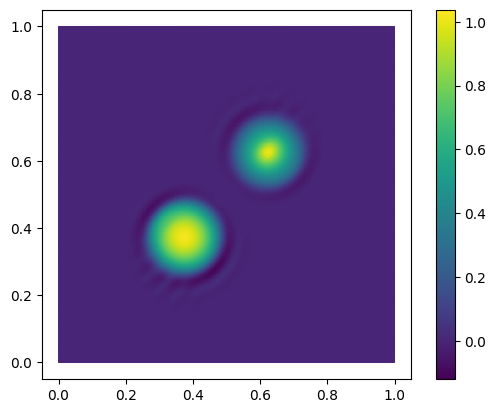

In [20]:
fig, axes = plt.subplots()
axes.set_aspect('equal')
colors = firedrake.tripcolor(q, axes=axes)
fig.colorbar(colors);

To be precise and for later comparison we'll print out exactly how far outside the initial range the solution goes.

In [21]:
q.dat.data_ro.min(), q.dat.data_ro.max()

(np.float64(-0.09991665375509991), np.float64(1.0251643060942375))

But of course we're only using the explicit Euler timestepping scheme, which is of first order, while our spatial discretization should be 2nd-order accurate.
Can we do better if we match the asymptotic accuracy of the errors in time and space?

### Timestepping

Choosing a finite element basis or a numerical flux is part of deciding how we'll discretize the spatial part of the differential operator.
After that we have to decide how to discretize in time.
The explicit Euler, which we used in the preceding code, has the virtue of simplicity.
Next we'll try out the *strong stability-preserving* Runge-Kutta method of order 3.
First, we'll create a form representing the rate of change of $q$ with the upwind flux just as we did before.

In [22]:
q = q0.copy(deepcopy=True)
ϕ = firedrake.TestFunction(Q1)
cell_flux = -inner(grad(ϕ), q * u) * dx

n = firedrake.FacetNormal(mesh)
u_n = max_value(inner(u, n), 0)
f = q * u_n
face_flux = (f('+') - f('-')) * (ϕ('+') - ϕ('-')) * dS

q_in = Constant(0)
influx = q_in * min_value(0, inner(u, n)) * ϕ * ds
outflux = q * max_value(0, inner(u, n)) * ϕ * ds

dq_dt = -(cell_flux + face_flux + influx + outflux)

To implement the SSPRK3 timestepping scheme, we'll introduce some auxiliary functions and solvers for the Runge-Kutta stages.

In [23]:
q1 = firedrake.Function(Q1)
q2 = firedrake.Function(Q1)

F2 = firedrake.replace(dq_dt, {q: q1})
F3 = firedrake.replace(dq_dt, {q: q2})

problems = [
    LinearVariationalProblem(m, dt * dq_dt, δq),
    LinearVariationalProblem(m, dt * F2, δq),
    LinearVariationalProblem(m, dt * F3, δq)
]

solvers = [
    LinearVariationalSolver(problem, solver_parameters=parameters)
    for problem in problems
]

The timestepping loop is more involved; we have to separately evaluate the Runge-Kutta stages and then form the solution as an appropriate weighted sum.

In [24]:
for step in trange(num_steps, unit='timesteps'):
    solvers[0].solve()
    q1.assign(q + δq)
    
    solvers[1].solve()
    q2.assign(3 * q / 4 + (q1 + δq) / 4)
    
    solvers[2].solve()
    q.assign(q / 3 + 2 * (q2 + δq) / 3)

  0%|          | 0/3412 [00:00<?, ?timesteps/s]

The SSPRK3 scheme gives a *huge* improvement in how well it agrees with the true solution.

In [25]:
firedrake.assemble(abs(q - q0) * dx) / firedrake.assemble(q0 * dx)

np.float64(0.0315854897444485)

In the eyeball norm, it looks like it stays pretty well wtihin the upper and lower limits of the initial data.

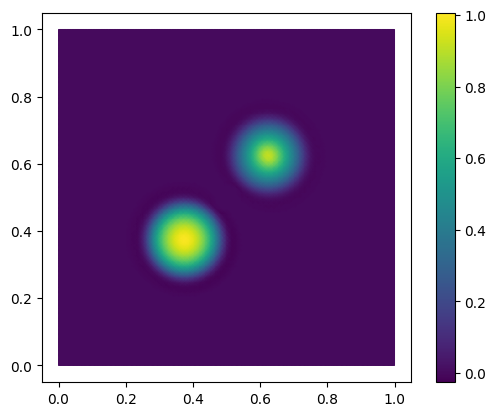

In [26]:
fig, axes = plt.subplots()
axes.set_aspect('equal')
colors = firedrake.tripcolor(q, axes=axes)
fig.colorbar(colors);

But if we explicitly calculate the upper and lower bounds, we see that this scheme also fails to be monotonicity preserving!

In [27]:
q.dat.data_ro.min(), q.dat.data_ro.max()

(np.float64(-0.015254743794348675), np.float64(1.0011548806442563))

The departures are relatively small but for more challenging or nonlinear problems the overshoots can become more severe.
There is (unfortunately) a can't-do theorem that tells us why: the [**Godunov barrier**](https://en.wikipedia.org/wiki/Godunov%27s_theorem).
This theorem states that **any linear, monotonicity-preserving scheme for hyperbolic conservation laws can be at most 1st-order accurate.**

In principle this might sound like a bit of a bummer; why bother looking for higher-order accurate numerical schemes if they're doomed to do unphysical things that will likely result in instability?
The operative word here is a *linear* scheme.
The Godunov barrier does not rule out the possibility of *nonlinear* monotonicity-preserving schemes.
I find it profoundly disturbing that we should be using nonlinear schemes to approximate the solutions of linear conservation laws, but ours is but to do and die I suppose.

### Flux limiters

The Godunov barrier motivated the development in the early 80s of post-processing techniques that would turn an otherwise oscillatory scheme into one that does not introduce new local maxima or minima.
These ideas fall under the aegis of flux limiters or slope limiters, which apply a transformation that clamps the solution in such a way as to suppress unrealistic gradients near sharp discontinuities but which leave the solution unaltered where it is smooth.
The design of limiters is part science and part art.
[Sweby (1984)](https://doi.org/10.1137/0721062) established some constraints on the what a good limiter function can look like in order to guarantee that the numerical scheme is variation-diminishing.
But there's a very large range within those constraints; Sweby's paper showed three different ones even in 1984 and the [wiki article](https://en.wikipedia.org/wiki/Flux_limiter) on flux limiters lists 15.

Flux-corrected transport is a huge subject, and rather than try to do it any kind of justice I'll instead refer you to a wonderful [book](https://www.mathematik.uni-dortmund.de/~kuzmin/Transport.pdf) by Dmitri Kuzmin.
Instead, let's finish things off by looking at what happens when we add a flux limiter to our simulation above.
The application of the limiter will be interleaved with all of the Runge-Kutta stages, and conveniently we can reuse the existing solvers for the SSPRK3 stages.

In [28]:
q.assign(q0)
limiter = firedrake.VertexBasedLimiter(Q1)

In [29]:
for step in trange(num_steps, unit='timesteps'):
    solvers[0].solve()
    q1.assign(q + δq)
    limiter.apply(q1)
    
    solvers[1].solve()
    q2.assign(3 * q / 4 + (q1 + δq) / 4)
    limiter.apply(q2)
    
    solvers[2].solve()
    q.assign(q / 3 + 2 * (q2 + δq) / 3)
    limiter.apply(q)

  0%|          | 0/3412 [00:00<?, ?timesteps/s]

The relative error in the 1-norm is just as good as before, but with the flux limiter the solution does a much better job staying within the bounds of the initial data.

In [30]:
firedrake.assemble(abs(q - q0) * dx) / firedrake.assemble(q0 * dx)

np.float64(0.027156220419849525)

In [31]:
q.dat.data_ro.min(), q.dat.data_ro.max()

(np.float64(-0.008129509947194852), np.float64(0.9836403522058974))

### Conclusion

Hyperbolic problems are hard.
There are difficult decisions to make even at the level of how to formulate the discrete problem.
For this demo, we were looking at a scalar conservation laws, and the upwind flux works quite well.
But for systems of conservation laws, like the shallow water equations, things become much more involved.
You have to know something at an analytical level about the underlying problem -- the wave speeds.
Once we've decided which discrete problem to solve, going beyond first-order accuracy is filled with even more challenges.
Some issues, like getting a stable enough timestep, often require manual tuning.
For the linear problem shown here, we know what the wave speeds are from the outset and we have reasonable confidence that we can pick a good timestep that will work for the entire simulation.
The solutions of nonlinear conservation laws can meander to regions of state space where the wave speeds are much higher than where they started and an initially stable timestep becomes unstable.
The Right Thing To Do is to use an adaptive timestepping scheme.
But you now have the added implementational difficulty of tracking a higher- and lower-order solution with which to inform the adaptation strategy.
Hopefully this has shown what some of the typical pitfalls are and what tools are available to remedy them.